## Robert Frost, meet Natural Language Processing

### Extract the data

In [1]:
# Dependencies to read the SQLite database
import pandas as pd
import sqlite3
from pprint import pprint

In [2]:
# Connect to the poetry database
conn = sqlite3.connect("db/Poetry.db")

# Load the data into a dataframe
df = pd.read_sql_query("select * from Frost;", conn)
conn.close()

# Print the dataframe
df.head()

,index,title,link,lines,poet
0,0,October,https://www.poetryfoundation.org/poems/53084/o...,"O hushed October morning mild,\nThy leaves hav...",Robert Frost
1,1,"‘Out, Out—’",https://www.poetryfoundation.org/poems/53087/o...,The buzz saw snarled and rattled in the yard\n...,Robert Frost
2,2,Acquainted with the Night,https://www.poetryfoundation.org/poems/47548/a...,I have been one acquainted with the night.\nI ...,Robert Frost
3,3,After Apple-Picking,https://www.poetryfoundation.org/poems/44259/a...,My long two-pointed ladder's sticking through ...,Robert Frost
4,4,Birches,https://www.poetryfoundation.org/poems/44260/b...,When I see birches bend to left and right\nAcr...,Robert Frost


In [3]:
# Choose the relevant columns
df1 = df[["index", "title", "poet"]]

In [4]:
# Remove special characters and their adjacent white spaces from each list of strings (lines) in each poem
lines = df["lines"].values.tolist()

df1["lines"] = [x.replace("\n", " ") for x in lines]
df1.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,index,title,poet,lines
0,0,October,Robert Frost,"O hushed October morning mild, Thy leaves have..."
1,1,"‘Out, Out—’",Robert Frost,The buzz saw snarled and rattled in the yard A...
2,2,Acquainted with the Night,Robert Frost,I have been one acquainted with the night. I h...
3,3,After Apple-Picking,Robert Frost,My long two-pointed ladder's sticking through ...
4,4,Birches,Robert Frost,When I see birches bend to left and right Acro...


In [5]:
# Put all letters in lower case
df1["lines"] = df1["lines"].str.lower()

# Preview the dataframe
df1.head()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,title,poet,lines
0,0,October,Robert Frost,"o hushed october morning mild, thy leaves have..."
1,1,"‘Out, Out—’",Robert Frost,the buzz saw snarled and rattled in the yard a...
2,2,Acquainted with the Night,Robert Frost,i have been one acquainted with the night. i h...
3,3,After Apple-Picking,Robert Frost,my long two-pointed ladder's sticking through ...
4,4,Birches,Robert Frost,when i see birches bend to left and right acro...


### Getting metadata about the poems

In [6]:
# Get the title, lines, poet, and poem number of each poem
poems = df1["title"].values.tolist()
index = df1["index"].values.tolist()
lines = df1["lines"].values.tolist()
poets = df1["poet"].values.tolist()

In [7]:
# Get information about publication year (various sources)
pubyear = [1913, 1916, 1928, 1914, 1916, 1916, 1923, 1923, 1928, 1923,
           1923, 1923, 1920, 1914, 1923, 1913, 1914, 1913, 1917, 1923,
           1916, 1913, 1923, 1923, 1923, 1914, 1942, 1923, 1916, 1914,
           1916, 1918, 1916, 1923, 1913, 1914, 1920]

In [8]:
# Get length of the entire poem for each poem
poem_length = [len(line.split()) for line in lines]

In [9]:
# list of unique words
unique_words = [list(set(line.split())) for line in lines]
unique_length = [len(x) for x in unique_words]

# Lexical diversity
lex_div = [round(unique_length[i] / poem_length[i], 4) for i in range(0, len(poem_length))]
lex_div

[0.7422,
 0.6271,
 0.6944,
 0.636,
 0.5626,
 0.5674,
 0.8235,
 0.8431,
 0.8085,
 0.746,
 0.7846,
 0.717,
 0.6345,
 0.4777,
 0.713,
 0.5905,
 0.553,
 0.6538,
 0.5864,
 0.85,
 0.7767,
 0.609,
 0.6944,
 0.6364,
 0.4925,
 0.4639,
 0.6068,
 0.6561,
 0.6842,
 0.7031,
 0.6667,
 0.6615,
 0.6644,
 0.4994,
 0.549,
 0.5637,
 0.6474]

### Transform the data

In [10]:
# Dependencies
import re, string

import nltk
# nltk.download("punkt")
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#### Tokenise, Remove Stop Words, Lemmatise
Reference for lemmatisation: https://marcobonzanini.com/2015/01/26/stemming-lemmatisation-and-pos-tagging-with-python-and-nltk/

In [11]:
# Remove stop words from the list
stops = stopwords.words("english")
exclude = set(string.punctuation)

# Lemmatise the words in each list to retain their roots
lemmatiser = WordNetLemmatizer()

In [12]:
# Transform the poem in preparation for word counts
words_list = []
preprocessed_text = []
for poem in df1["lines"]:
    
    # Create a list of words per poem after the words are converted to lowercase    
    words = word_tokenize(poem)
    
    # Filter to remove stop words and punctuations    
    words2 = [word for word in words if word not in stops and word not in exclude]
    
    # Lemmatise each word (if it's a verb, convert to root verb)
    words3 = [lemmatiser.lemmatize(word, pos = "v") for word in words2]
    
    # Add the filtered list of words (representing each poem)
    words_list.append(words3)
    
    # Convert the list of strings back to one string
    words4 = " ".join(words3)
    
    # Add the filtered list of words (representing each poem)
    preprocessed_text.append(words4)

df1["tokens"] = words_list    
df1["filteredPoem"] = preprocessed_text
df1.head()

,index,title,poet,lines,tokens,filteredPoem
0,0,October,Robert Frost,"o hushed october morning mild, thy leaves have...","[hush, october, morning, mild, thy, leave, rip...",hush october morning mild thy leave ripen fall...
1,1,"‘Out, Out—’",Robert Frost,the buzz saw snarled and rattled in the yard a...,"[buzz, saw, snarl, rattle, yard, make, dust, d...",buzz saw snarl rattle yard make dust drop stov...
2,2,Acquainted with the Night,Robert Frost,i have been one acquainted with the night. i h...,"[one, acquaint, night, walk, rain—and, back, r...",one acquaint night walk rain—and back rain out...
3,3,After Apple-Picking,Robert Frost,my long two-pointed ladder's sticking through ...,"[long, two-pointed, ladder, 's, stick, tree, t...",long two-pointed ladder 's stick tree toward h...
4,4,Birches,Robert Frost,when i see birches bend to left and right acro...,"[see, birch, bend, leave, right, across, line,...",see birch bend leave right across line straigh...


In [13]:
# Create a function that counts the number of words in each poem
def word_count(word_list):
    return len(word_list)

In [14]:
# Determine the length of each filtered poem
lengths = []
for poem in df1["tokens"]:
    length = word_count(poem)
    lengths.append(length)

# Add the filtered poem lengths in the df
df1["poemLength"] = lengths
df1.head()

,index,title,poet,lines,tokens,filteredPoem,poemLength
0,0,October,Robert Frost,"o hushed october morning mild, thy leaves have...","[hush, october, morning, mild, thy, leave, rip...",hush october morning mild thy leave ripen fall...,83
1,1,"‘Out, Out—’",Robert Frost,the buzz saw snarled and rattled in the yard a...,"[buzz, saw, snarl, rattle, yard, make, dust, d...",buzz saw snarl rattle yard make dust drop stov...,159
2,2,Acquainted with the Night,Robert Frost,i have been one acquainted with the night. i h...,"[one, acquaint, night, walk, rain—and, back, r...",one acquaint night walk rain—and back rain out...,54
3,3,After Apple-Picking,Robert Frost,my long two-pointed ladder's sticking through ...,"[long, two-pointed, ladder, 's, stick, tree, t...",long two-pointed ladder 's stick tree toward h...,142
4,4,Birches,Robert Frost,when i see birches bend to left and right acro...,"[see, birch, bend, leave, right, across, line,...",see birch bend leave right across line straigh...,252


In [15]:
# Number of poems
print (f"There are {df1.shape[0]} poems written by Robert Frost in the dataframe.")

There are 37 poems written by Robert Frost in the dataframe.


In [16]:
# Longest and shortest poems
longest_poem = df1["poemLength"].max()
shortest_poem = df1["poemLength"].min()

for i in range(0, len(df1["poemLength"])):
    if df1["poemLength"][i] == longest_poem:
        print(f'Longest poem: {df1["title"][i]}; Filtered poem length: {df1["poemLength"][i]} words')
    if df1["poemLength"][i] == shortest_poem:
        print(f'Shortest poem: {df1["title"][i]}; Filtered poem length: {df1["poemLength"][i]} words')      

Shortest poem: Dust of Snow; Filtered poem length: 15 words
Longest poem: The Death of the Hired Man; Filtered poem length: 787 words


### Word importance
Source: https://stevenloria.com/tf-idf/

In [17]:
# Dependencies
import math
from textblob import TextBlob as tb

In [18]:
# Create a function that calculates term frequency
def tf(word, poem):
    return poem.words.count(word) / len(poem.words)

# Create a function that determines the number of documents that contain a certain word
def n_docs(word, poemlist):
    return sum(1 for poem in poemlist if word in poem.words)

# Create a function that determines the inverse document frequency (IDF)
# IDF = how common a word is among all the documents in poemlist
def idf(word, poemlist):
    return math.log(len(poemlist) / (1 + n_docs(word, poemlist)))

def tdidf(word, poem, poemlist):
    return tf(word, poem) * idf(word, poemlist)

In [19]:
# Create the poemlist from df["lines"]
poemlist = [tb(poem) for poem in df1["filteredPoem"]]
poemlist

[TextBlob("hush october morning mild thy leave ripen fall tomorrow ’ wind wild waste crow forest call tomorrow may form go hush october morning mild begin hours day slow make day seem us less brief hearts averse beguile beguile us way know release one leaf break day noon release another leaf one tree one far away retard sun gentle mist enchant land amethyst slow slow grapes ’ sake whose leave already burn frost whose cluster fruit must else lost— grapes ’ sake along wall"),
 TextBlob("buzz saw snarl rattle yard make dust drop stove-length stick wood sweet-scented stuff breeze draw across lift eye could count five mountain range one behind sunset far vermont saw snarl rattle snarl rattle run light bear load nothing happen day do call day wish might say please boy give half hour boy count much save work sister stand beside apron tell ‘ supper. ’ word saw prove saw know supper mean leap boy ’ hand seem leap— must give hand however neither refuse meet hand boy ’ first outcry rueful laugh s

In [20]:
# Create an empty list to be filled with text blobs from cleaning poemlist
poemlist2 = []

# Loop through the poemlist
for i in range(0, len(poemlist)):
    
    # Remove words that are shorter than 3 characters
    new_string = ' '.join([w for w in str(poemlist[i]).split() if len(w) > 3])
    
    # Replace emm dash with space
    new_string2 = new_string.replace("—", " ")
    
    # Convert string to text blob
    new_string2 = tb(new_string2)
    
    # Append the text blob to the list of text blobs
    poemlist2.append(new_string2)
    
poemlist2

[TextBlob("hush october morning mild leave ripen fall tomorrow wind wild waste crow forest call tomorrow form hush october morning mild begin hours slow make seem less brief hearts averse beguile beguile know release leaf break noon release another leaf tree away retard gentle mist enchant land amethyst slow slow grapes sake whose leave already burn frost whose cluster fruit must else lost  grapes sake along wall"),
 TextBlob("buzz snarl rattle yard make dust drop stove-length stick wood sweet-scented stuff breeze draw across lift could count five mountain range behind sunset vermont snarl rattle snarl rattle light bear load nothing happen call wish might please give half hour count much save work sister stand beside apron tell supper. word prove know supper mean leap hand seem leap  must give hand however neither refuse meet hand first outcry rueful laugh swing toward hold hand half appeal half keep life spill all  since enough know work though child heart  spoil hand off  doctor come

In [21]:
# Calculate the most important words
impt_words = []
for i, poem in enumerate(poemlist2):
    scores = {word: tdidf(word, poem, poemlist2) for word in poem.words}
    sorted_words = sorted(scores.items(), key = lambda x: x[1], reverse = True)
    
    for word, score in sorted_words[:5]:
        impt_words.append((i, word, round(score, 5)))

In [22]:
impt_words

[(0, 'slow', 0.1142),
 (0, 'hush', 0.08842),
 (0, 'october', 0.08842),
 (0, 'mild', 0.08842),
 (0, 'beguile', 0.08842),
 (1, 'snarl', 0.07234),
 (1, 'rattle', 0.06229),
 (1, 'half', 0.06229),
 (1, 'hand', 0.06015),
 (1, 'sister', 0.04823),
 (2, 'acquaint', 0.12416),
 (2, 'rain', 0.10691),
 (2, 'city', 0.10691),
 (2, 'outwalked', 0.06208),
 (2, 'furthest', 0.06208),
 (3, 'apples', 0.09726),
 (3, 'sleep', 0.09096),
 (3, 'ladder', 0.04863),
 (3, 'apple-picking', 0.04863),
 (3, 'thousand', 0.03708),
 (4, 'birch', 0.04449),
 (4, 'learn', 0.04377),
 (4, 'climb', 0.03337),
 (4, 'break', 0.03063),
 (4, 'swinger', 0.02918),
 (5, 'christmas', 0.05953),
 (5, 'sell', 0.04763),
 (5, 'thousand', 0.04217),
 (5, 'cents', 0.04148),
 (5, 'city', 0.03572),
 (6, 'hemlock', 0.24315),
 (6, 'mood', 0.24315),
 (6, 'crow', 0.20936),
 (6, 'dust', 0.18539),
 (6, 'part', 0.18539),
 (7, 'fire', 0.20213),
 (7, 'taste', 0.1621),
 (7, 'favor', 0.1621),
 (7, 'perish', 0.1621),
 (7, 'destruction', 0.1621),
 (8, 'star',

In [23]:
# Create a dataframe of important words per poem
df2 = pd.DataFrame(impt_words, columns = ["PoemNo", "Word", "TF-IDF"])
df2["Poet"] = "Robert Frost"
df2.head()

,PoemNo,Word,TF-IDF,Poet
0,0,slow,0.11420,Robert Frost
1,0,hush,0.08842,Robert Frost
2,0,october,0.08842,Robert Frost
3,0,mild,0.08842,Robert Frost
4,0,beguile,0.08842,Robert Frost


In [24]:
# Save df2 as a sqlite database table (for Javascript use later)
conn = sqlite3.connect("db/Poetry.db")

# Create a database table from the dataframe
df2.to_sql("tfidf", conn, if_exists = "replace", index = False)

# Preview the database table
pd.read_sql_query("select * from tfidf;", conn).head()

,PoemNo,Word,TF-IDF,Poet
0,0,slow,0.11420,Robert Frost
1,0,hush,0.08842,Robert Frost
2,0,october,0.08842,Robert Frost
3,0,mild,0.08842,Robert Frost
4,0,beguile,0.08842,Robert Frost


In [25]:
conn.close()

In [26]:
# Add titles for each poem in df2
titles = []
for i in range(0, len(df)):
    for p in df2.PoemNo:
        if i == p:
            title = df["title"][i]
            titles.append(title) 

df2["PoemTitle"] = titles

# Preview
df2.head()

,PoemNo,Word,TF-IDF,Poet,PoemTitle
0,0,slow,0.11420,Robert Frost,October
1,0,hush,0.08842,Robert Frost,October
2,0,october,0.08842,Robert Frost,October
3,0,mild,0.08842,Robert Frost,October
4,0,beguile,0.08842,Robert Frost,October


In [27]:
# Group the important words by poem title
df3 = pd.DataFrame(df2.groupby(["PoemTitle", "Word"])["TF-IDF"].mean())
df3

TF-IDF
PoemTitle                 Word                  
Acquainted with the Night acquaint       0.12416
                          city           0.10691
                          furthest       0.06208
                          outwalked      0.06208
                          rain           0.10691
After Apple-Picking       apple-picking  0.04863
                          apples         0.09726
                          ladder         0.04863
                          sleep          0.09096
                          thousand       0.03708
Birches                   birch          0.04449
                          break          0.03063
                          climb          0.03337
                          learn          0.04377
                          swinger        0.02918
Christmas Trees           cents          0.04148
                          christmas      0.05953
                          city           0.03572
                          sell           0.04763
                          thousand       0.04217
Dust of Snow              crow           0.20936
                          dust           0.18539
                          hemlock        0.24315
                          mood           0.24315
                          part           0.18539
Fire and Ice              destruction    0.16210
                          favor          0.16210
                          fire           0.20213
                          perish         0.16210
                          taste          0.16210
...                                          ...
The Sound of Trees        noise          0.08973
                          shall          0.12994
                          suffer         0.05210
                          sway           0.08973
                          talk           0.07148
The Star-splitter         farm           0.05174
                          sell           0.03339
                          split          0.03339
                          star           0.04173
                          telescope      0.05816
The Tuft of Flowers       butterfly      0.04801
                          grass          0.05422
                          scythe         0.05422
                          together       0.05422
                          work           0.07200
The Wood-Pile             forget         0.04198
                          gray           0.04198
                          pile           0.04198
                          swamp          0.04198
                          year           0.05760
To E. T.                  dive           0.04945
                          half-read      0.04945
                          poems          0.04945
                          slumber        0.04945
                          tomb           0.04945
‘Out, Out—’               half           0.06229
                          hand           0.06015
                          rattle         0.06229
                          sister         0.04823
                          snarl          0.07234

[185 rows x 1 columns]

### Visualise the important words

In [28]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid")
import numpy as np

from ipywidgets import widgets, interactive

In [29]:
# Create a widget containing poem titles (sorted alphabetically)
titles = list(df.title)
titles.sort()

poem_title = widgets.Dropdown(options = ["Choose a poem..."] + titles, value = "Choose a poem...", 
                              description = "Title:", disabled = False)

In [30]:
# Create a filter based on title
def plot_it(poem_title):
    if poem_title != "Choose a poem...":
        df3 = df2[df2["PoemTitle"] == poem_title]
        
        plt.figure(figsize = (10, 6))
        sns.set(font_scale = 1.5)
        graph = sns.barplot(y = "Word", x = "TF-IDF", data = df3, palette = "Blues_d")

In [31]:
# Plot the data by poem title
interactive(plot_it, poem_title = poem_title)

interactive(children=(Dropdown(description='Title:', options=('Choose a poem...', 'Acquainted with the Night',…

### Sentiment Analysis - Metadata

In [32]:
# Predict sentiments based on textblobs
sentiment_polarity = [round(poem.sentiment.polarity, 3) \
                      for poem in poemlist2]
sentiment_cat = ["positive" if sp > 0
                 else "negative" if sp < 0
                 else "neutral"
                 for sp in sentiment_polarity]

In [33]:
metadata = pd.DataFrame({"PoemNo": index,
                         "Poet": poets,
                         "Title": poems,
                         "Content": lines,
                         "Length": poem_length,
                         "Sentiment": sentiment_cat,
                         "Pubn_Year": pubyear,
                         "Lexical_Diversity": lex_div}, 
                        columns = ["PoemNo", "Poet", "Title", "Length", 
                                   "Content", "Sentiment", "Pubn_Year", "Lexical_Diversity"])
metadata.head()

,PoemNo,Poet,Title,Length,Content,Sentiment,Pubn_Year,Lexical_Diversity
0,0,Robert Frost,October,128,"o hushed october morning mild, thy leaves have...",negative,1913,0.7422
1,1,Robert Frost,"‘Out, Out—’",295,the buzz saw snarled and rattled in the yard a...,negative,1916,0.6271
2,2,Robert Frost,Acquainted with the Night,108,i have been one acquainted with the night. i h...,positive,1928,0.6944
3,3,Robert Frost,After Apple-Picking,283,my long two-pointed ladder's sticking through ...,positive,1914,0.6360
4,4,Robert Frost,Birches,503,when i see birches bend to left and right acro...,positive,1916,0.5626


In [34]:
# Save df2 as a sqlite database table (for Javascript use later)
conn = sqlite3.connect("db/Poetry.db")

# Create a database table from the dataframe
metadata.to_sql("metadata", conn, if_exists = "replace", index = False)

# Preview the database table
pd.read_sql_query("select * from metadata;", conn).head()

,PoemNo,Poet,Title,Length,Content,Sentiment,Pubn_Year,Lexical_Diversity
0,0,Robert Frost,October,128,"o hushed october morning mild, thy leaves have...",negative,1913,0.7422
1,1,Robert Frost,"‘Out, Out—’",295,the buzz saw snarled and rattled in the yard a...,negative,1916,0.6271
2,2,Robert Frost,Acquainted with the Night,108,i have been one acquainted with the night. i h...,positive,1928,0.6944
3,3,Robert Frost,After Apple-Picking,283,my long two-pointed ladder's sticking through ...,positive,1914,0.6360
4,4,Robert Frost,Birches,503,when i see birches bend to left and right acro...,positive,1916,0.5626


### Topic Modelling
Sources: 
1. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
2. https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [35]:
# Gensim 
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [36]:
tokens = df1["tokens"].tolist()

In [37]:
# Build the bigram and the trigram model
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens], threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [38]:
def process_words(texts, stop_words = stops, allowed_postags = ["NOUN", "ADJ", "ADV"]):
    """ Remove stop words, create bigrams and trigrams, lemmatise """
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]    
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    nlp = spacy.load("en", disable = ["parser", "ner"])
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
        # remove stop words (again)         
        texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] \
                     for doc in texts_out]
        
        # remove words shorter than three letters       
        texts_out = [[word for word in lst if len(word) > 2] for lst in texts_out]

    return texts_out

In [39]:
filtered_text = process_words(tokens)

In [40]:
filtered_text

[['hush',
  'october',
  'morning',
  'mild',
  'leave',
  'ripen',
  'fall',
  'tomorrow',
  'wind',
  'wild',
  'waste',
  'crow',
  'forest',
  'call',
  'tomorrow',
  'hush',
  'october',
  'morning',
  'mild',
  'hour',
  'day',
  'slow',
  'make',
  'day',
  'less',
  'brief',
  'heart',
  'averse',
  'beguile',
  'way',
  'release',
  'leaf',
  'break',
  'day',
  'noon',
  'leaf',
  'tree',
  'far',
  'away',
  'retard',
  'sun',
  'gentle',
  'mist',
  'enchant',
  'land',
  'amethyst',
  'slow',
  'slow',
  'grape',
  'sake',
  'already',
  'frost',
  'cluster',
  'fruit',
  'else',
  'grape',
  'sake',
  'wall'],
 ['snarl',
  'rattle',
  'yard',
  'dust',
  'stove',
  'length',
  'stick',
  'wood',
  'sweet',
  'scented',
  'stuff',
  'breeze',
  'draw',
  'lift',
  'eye',
  'mountain',
  'range',
  'sunset',
  'far',
  'vermont',
  'snarl',
  'rattle',
  'snarl',
  'rattle',
  'run',
  'light',
  'bear',
  'load',
  'nothing',
  'day',
  'call',
  'day',
  'wish',
  'half',

In [41]:
# Create dictionary
id2words = corpora.Dictionary(filtered_text)

# Create corpus term frequency (convert dictionary to bag-of-words)
corpus = [id2words.doc2bow(text) for text in filtered_text]

#### How many topics?

In [42]:
# Create a range of number of topics
num_topics = list(range(1, 21))
num_topics

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [43]:
# Define a function that calculates the coherence score 
def coherence_score(num_topics):
    """ Create a LDA model """
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2words,
                                            num_topics = num_topics,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 20,
                                            alpha = "auto",
                                            per_word_topics = True)
    
    """ Calculate the coherence score """
    coherence_model_lda = CoherenceModel(model = lda_model, 
                                         texts = filtered_text, 
                                         dictionary = id2words,
                                         coherence = 'c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    return coherence_lda

In [44]:
# Calculate the coherence score of each number of topics
coh_score = [coherence_score(x) for x in num_topics]
coh_score

[0.15467209964865877,
 0.1892830842172082,
 0.24303879174146217,
 0.2757926494838445,
 0.26763760691996574,
 0.31745232588814526,
 0.31530427116828724,
 0.33039516948445313,
 0.34898631973310335,
 0.31601655944822704,
 0.3865837191414418,
 0.360661028495783,
 0.3240284381235868,
 0.3533467602866868,
 0.37364607442874237,
 0.3710836861711344,
 0.34767276692130034,
 0.41536597330830716,
 0.36826872843063846,
 0.38787016563190896]

Text(0,0.5,'Coherence score')

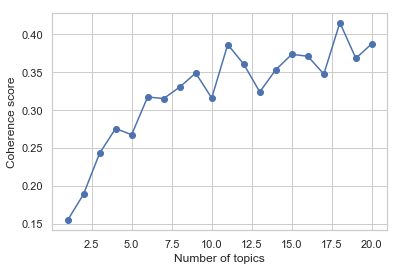

In [45]:
# Plot number of topics vs coherence score
# Find the highest coherence score before the trend flattens out
plt.plot(num_topics, coh_score, "bo-")
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")

In [46]:
# Building the LDA model using the chosen number of topics
final_number = 6

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2words,
                                            num_topics = final_number,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 20,
                                            alpha = "auto",
                                            per_word_topics = True)

# Compute Perplexity
print(f"Perplexity: {lda_model.log_perplexity(corpus)}")

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, 
                                     texts = filtered_text, 
                                     dictionary = id2words, 
                                     coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Perplexity: -7.109615515458735
Coherence Score: 0.31745232588814526


In [47]:
# Keywords for the top 10 topics
doc_lda = lda_model[corpus]
pprint(lda_model.print_topics())

[(0,
  '0.013*"sleep" + 0.011*"tree" + 0.011*"apple" + 0.009*"house" + 0.009*"fall" '
  '+ 0.009*"year" + 0.009*"people" + 0.009*"count" + 0.009*"none" + '
  '0.008*"long"'),
 (1,
  '0.014*"tree" + 0.013*"something" + 0.011*"never" + 0.011*"city" + '
  '0.009*"still" + 0.009*"land" + 0.009*"christmas" + 0.007*"wind" + '
  '0.007*"blow" + 0.007*"whisper"'),
 (2,
  '0.013*"hand" + 0.012*"boy" + 0.008*"half" + 0.008*"bridegroom" + '
  '0.008*"tree" + 0.007*"back" + 0.007*"nothing" + 0.007*"wish" + 0.007*"day" '
  '+ 0.007*"heart"'),
 (3,
  '0.012*"little" + 0.012*"back" + 0.012*"man" + 0.010*"eye" + 0.007*"time" + '
  '0.007*"alone" + 0.007*"together" + 0.006*"stone" + 0.006*"work" + '
  '0.006*"earth"'),
 (4,
  '0.012*"thing" + 0.012*"way" + 0.009*"day" + 0.009*"good" + 0.009*"house" + '
  '0.009*"farm" + 0.008*"telescope" + 0.008*"star" + 0.007*"wood" + '
  '0.007*"year"'),
 (5,
  '0.012*"good" + 0.010*"wall" + 0.009*"thing" + 0.008*"wood" + '
  '0.008*"nothing" + 0.008*"little" + 0.007

### Most important words per topic

In [48]:
# Dependencies
import pyLDAvis
import pyLDAvis.gensim

In [49]:
# Create graphs of most important words per topic
# Based on the LDA model

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda_model, corpus, id2words)
panel

/anaconda3/envs/PythonData/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.040633 -0.022401       1        1  28.105360
4      0.069252 -0.109302       2        1  18.373814
3     -0.041632 -0.052130       3        1  16.402098
2     -0.095156  0.058892       4        1  13.691547
1      0.109843  0.092381       5        1  12.112432
0     -0.001674  0.032559       6        1  11.314747, topic_info=     Category       Freq        Term      Total  loglift  logprob
term                                                             
188   Default   7.000000       sleep   7.000000  30.0000  30.0000
52    Default   8.000000         boy   8.000000  29.0000  29.0000
142   Default   6.000000       apple   6.000000  28.0000  28.0000
115   Default   4.000000        city   4.000000  27.0000  27.0000
40    Default  20.000000        tree  20.000000  26.0000  26.0000
398   Default   6.000000        star   6.000000  25.0000  25.0000
364   Default  11.000000   something  11.000000  24.0000  24.0000
844   Default   3.000000        none   3.000000  23.0000  23.0000
823   Default   4.000000       count   4.000000  22.0000  22.0000
64    Default   9.000000         eye   9.000000  21.0000  21.0000
468   Default   7.000000        farm   7.000000  20.0000  20.0000
312   Default   4.000000   christmas   4.000000  19.0000  19.0000
1167  Default   5.000000   telescope   5.000000  18.0000  18.0000
67    Default   4.000000        half   4.000000  17.0000  17.0000
636   Default   4.000000  bridegroom   4.000000  16.0000  16.0000
23    Default   5.000000        land   5.000000  15.0000  15.0000
572   Default   6.000000      people   6.000000  14.0000  14.0000
607   Default   4.000000    together   4.000000  13.0000  13.0000
205   Default   5.000000       alone   5.000000  12.0000  12.0000
13    Default   7.000000        fall   7.000000  11.0000  11.0000
803   Default   3.000000        blow   3.000000  10.0000  10.0000
41    Default  11.000000        wall  11.000000   9.0000   9.0000
718   Default   3.000000     whisper   3.000000   8.0000   8.0000
259   Default  12.000000       never  12.000000   7.0000   7.0000
65    Default   6.000000       first   6.000000   6.0000   6.0000
521   Default   9.000000        door   9.000000   5.0000   5.0000
68    Default  14.000000        hand  14.000000   4.0000   4.0000
173   Default   8.000000        long   8.000000   3.0000   3.0000
43    Default  15.000000         way  15.000000   2.0000   2.0000
212   Default   5.000000       birch   5.000000   1.0000   1.0000
...       ...        ...         ...        ...      ...      ...
148    Topic6   1.340993       bough   2.563411   1.5311  -5.5299
630    Topic6   1.340800      autumn   2.591126   1.5202  -5.5300
588    Topic6   1.340675     silence   2.630676   1.5050  -5.5301
13     Topic6   3.197446        fall   7.401412   1.3397  -4.6609
865    Topic6   1.340708       table   2.729577   1.4681  -5.5301
826    Topic6   1.340711     declare   2.729594   1.4681  -5.5301
292    Topic6   1.340645       trunk   3.253762   1.2924  -5.5301
302    Topic6   3.197360        year  11.814604   0.8721  -4.6610
173    Topic6   2.578966        long   8.587319   0.9762  -4.8759
613    Topic6   1.340745       woman   3.332687   1.2685  -5.5301
521    Topic6   2.578679        door   9.240999   0.9027  -4.8760
618    Topic6   1.340714     forever   3.455318   1.2324  -5.5301
40     Topic6   3.817422        tree  20.405949   0.5028  -4.4837
424    Topic6   1.959813        bird   7.004988   0.9053  -5.1504
123    Topic6   3.197605       house  16.939571   0.5118  -4.6609
152    Topic6   1.341144       clear   4.027109   1.0795  -5.5298
284    Topic6   1.340909      summer   4.027628   1.0792  -5.5299
42     Topic6   1.340758       waste   4.103881   1.0604  -5.5301
79     Topic6   2.578942         man  15.879992   0.3614  -4.8759
136    Topic6   1.959728        time  12.694379   0.3107  -5.1505
82     Topic6   1.959833   

In [50]:
# Save the graph as a html page
pyLDAvis.save_html(panel, "lda.html")

### Dominant Topic in each poem

In [51]:
def format_topics_sentences(doc_lda, ldamodel = lda_model, texts = tokens):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(doc_lda):
        row = row_list[0] if ldamodel.per_word_topics else row_list 
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), \
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(doc_lda, ldamodel = lda_model, texts = tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.9974,"thing, way, day, good, house, farm, telescope,...","[hush, october, morning, mild, thy, leave, rip..."
1,1,2.0,0.9984,"hand, boy, half, bridegroom, tree, back, nothi...","[buzz, saw, snarl, rattle, yard, make, dust, d..."
2,2,1.0,0.9962,"tree, something, never, city, still, land, chr...","[one, acquaint, night, walk, rain—and, back, r..."
3,3,0.0,0.9983,"sleep, tree, apple, house, fall, year, people,...","[long, two-pointed, ladder, 's, stick, tree, t..."
4,4,2.0,0.9991,"hand, boy, half, bridegroom, tree, back, nothi...","[see, birch, bend, leave, right, across, line,..."
5,5,1.0,0.9989,"tree, something, never, city, still, land, chr...","[city, withdraw, leave, last, country, country..."
6,6,0.0,0.9874,"sleep, tree, apple, house, fall, year, people,...","[way, crow, shake, dust, snow, hemlock, tree, ..."
7,7,5.0,0.9912,"good, wall, thing, wood, nothing, little, back...","[say, world, end, fire, say, ice, ’, taste, de..."
8,8,1.0,0.9927,"tree, something, never, city, still, land, chr...","[come, real, star, fill, upper, sky, earth, co..."
9,9,1.0,0.9967,"tree, something, never, city, still, land, chr...","[others, taunt, kneel, well-curbs, always, wro..."


### Data Visualisation

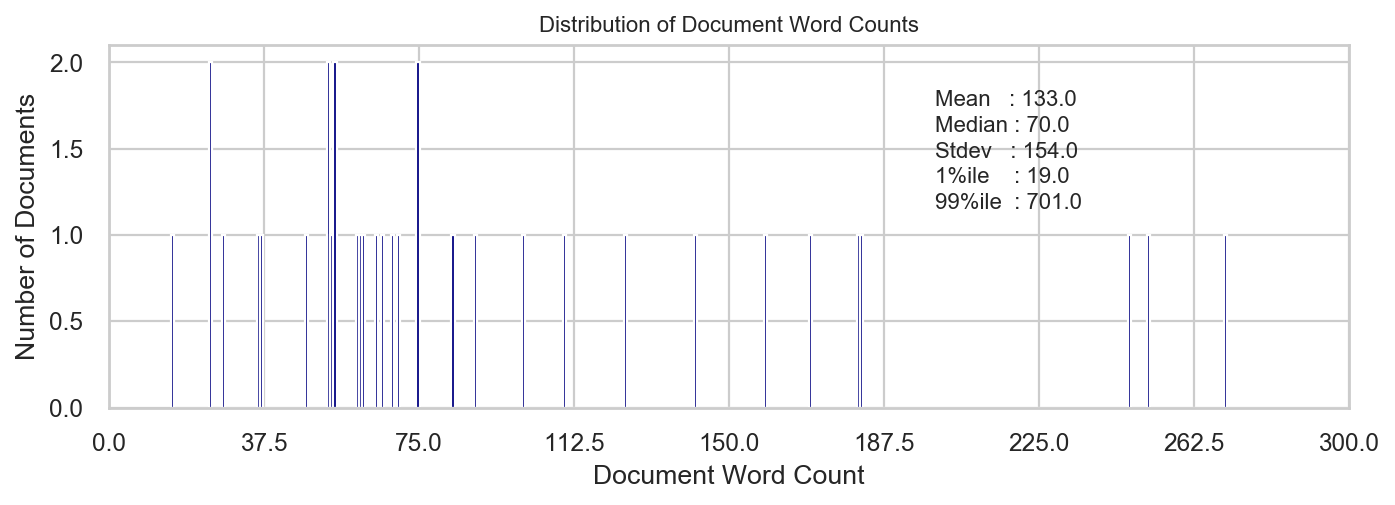

In [52]:
# Length of text per tokenised poem
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize = (10,3), dpi = 160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(200, 1.75, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(200, 1.60, "Median : " + str(round(np.median(doc_lens))))
plt.text(200, 1.45, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(200, 1.30, "1%ile    : " + str(round(np.quantile(doc_lens, q = 0.01))))
plt.text(200, 1.15, "99%ile  : " + str(round(np.quantile(doc_lens, q = 0.99))))

plt.gca().set(xlim = (0, 300), ylabel = 'Number of Documents', xlabel = 'Document Word Count')
plt.tick_params(size = 8)
plt.xticks(np.linspace(0, 300, 9))
plt.title('Distribution of Document Word Counts', fontdict = dict(size = 10))
plt.show()

/anaconda3/envs/PythonData/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


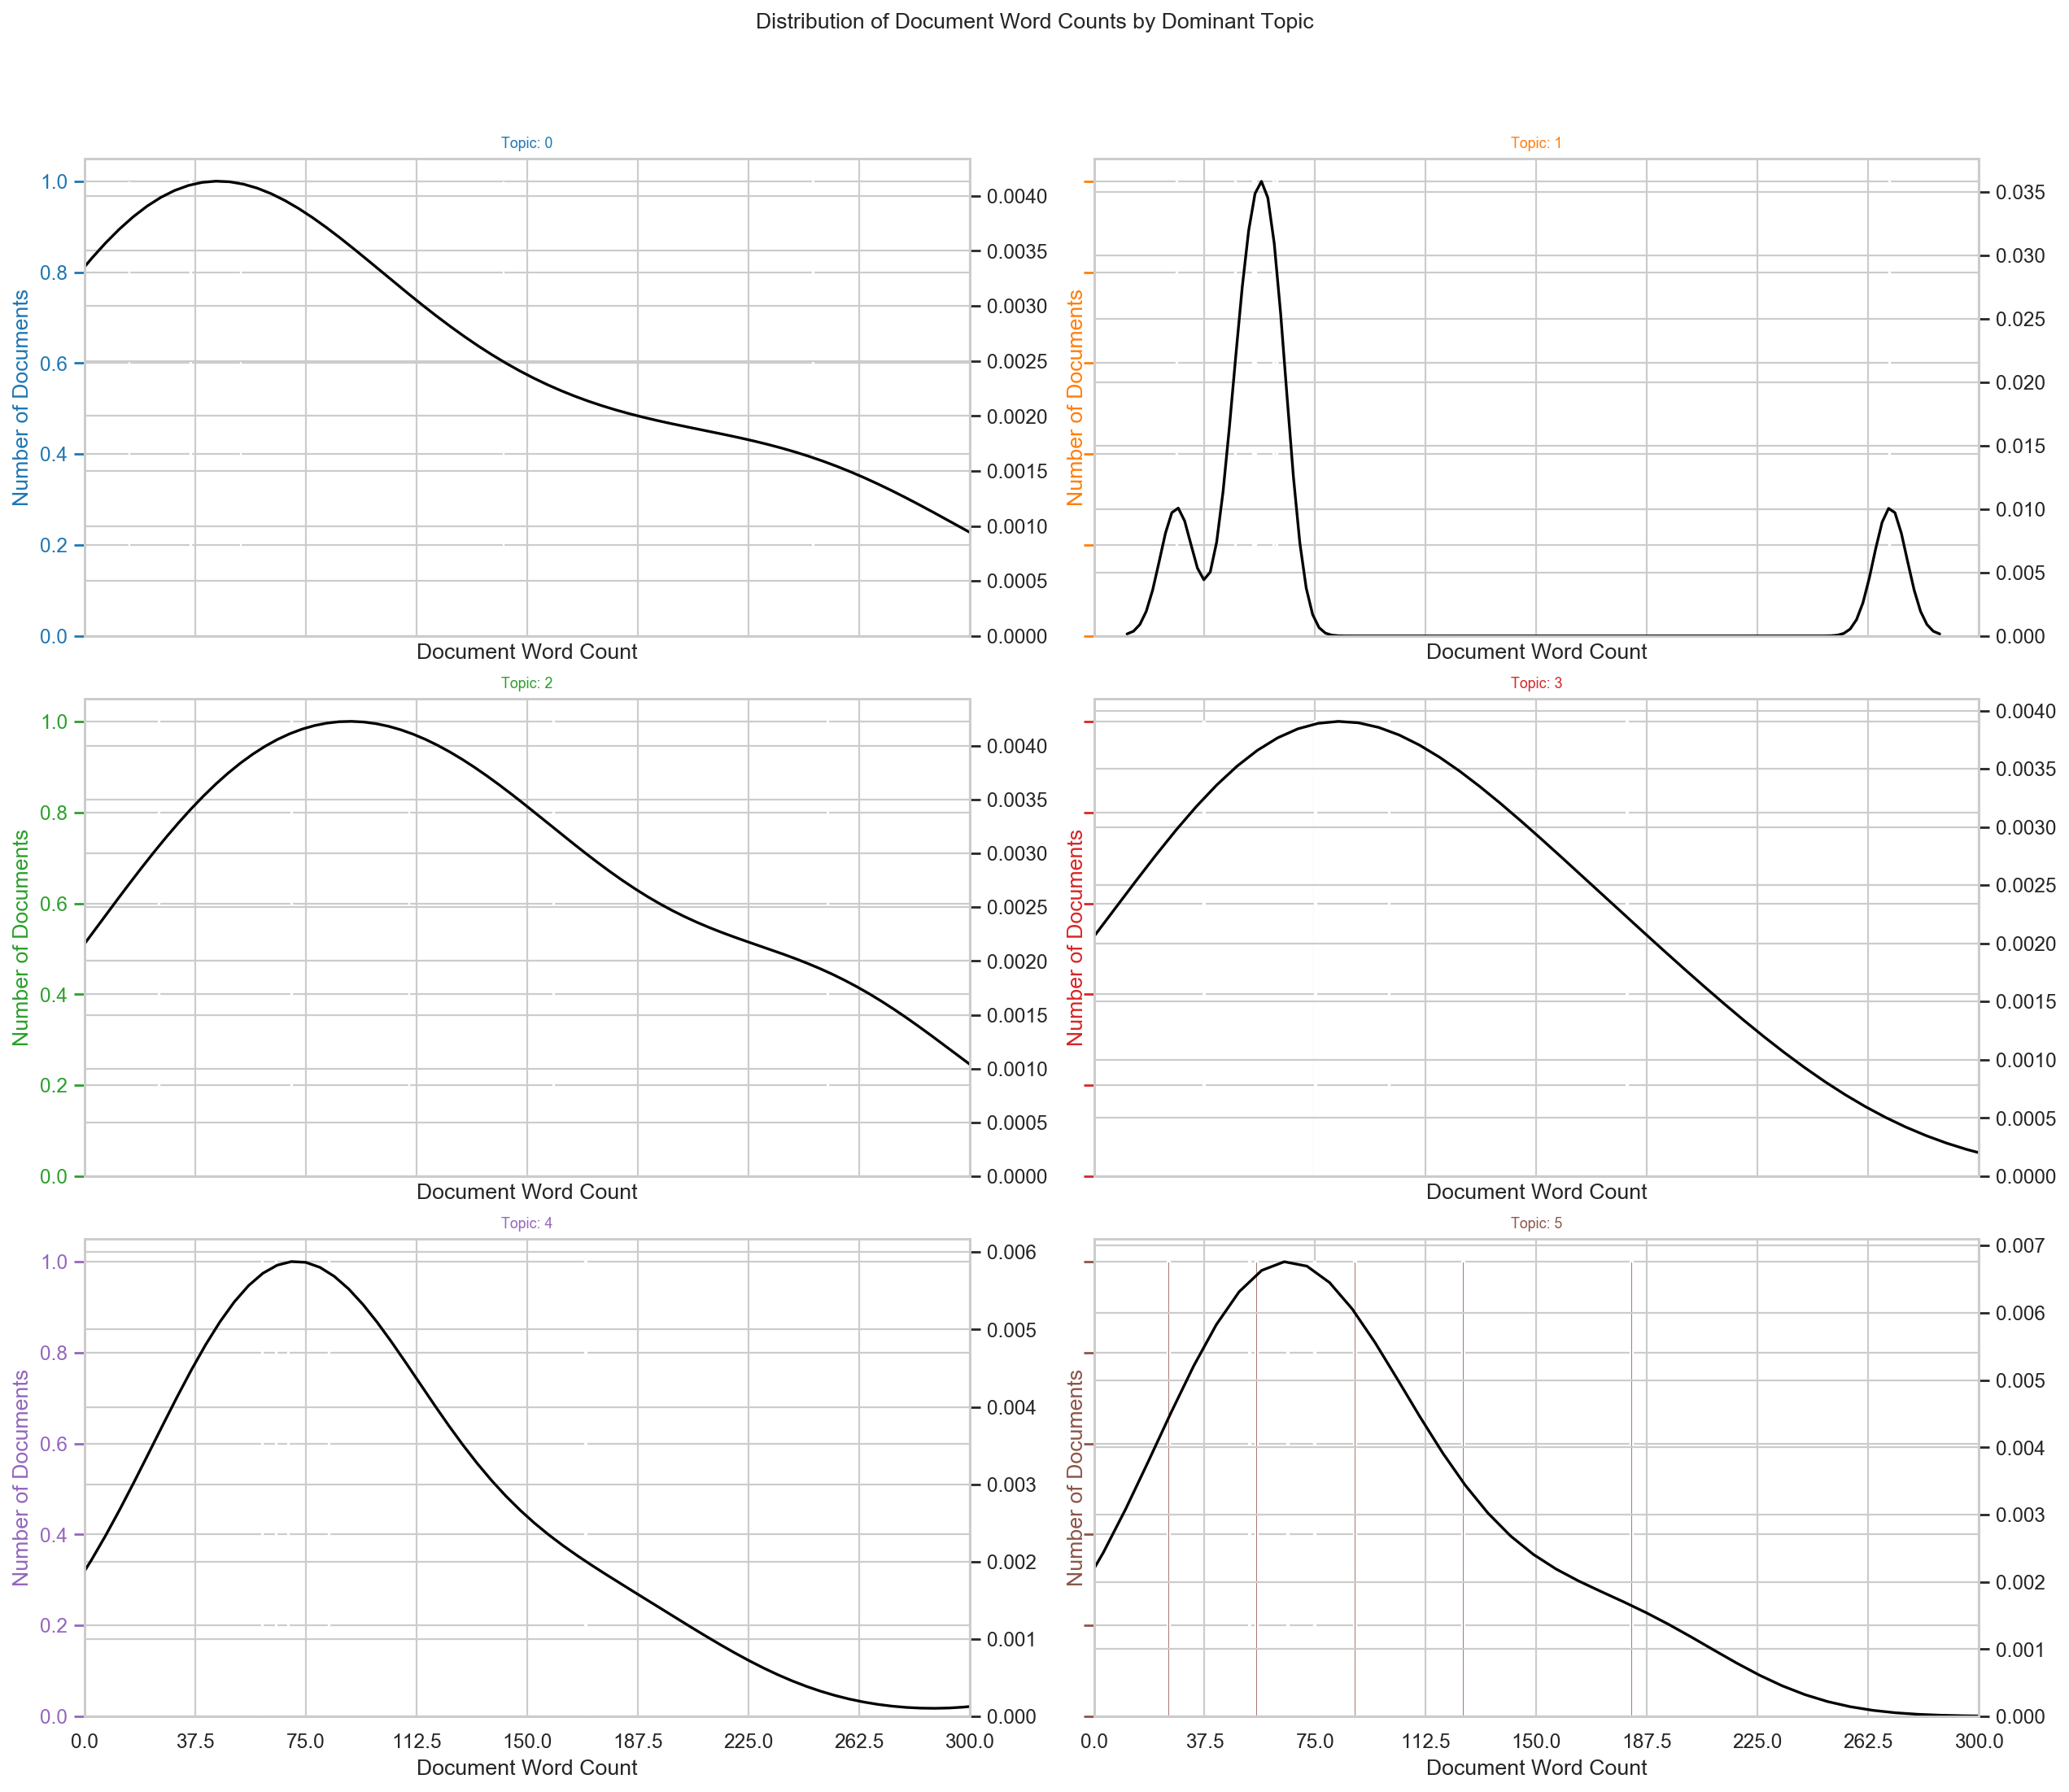

In [53]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2, figsize = (16,14), dpi = 160, sharex = True, sharey = True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color = cols[i])
    ax.tick_params(axis = 'y', labelcolor = cols[i], color = cols[i])
    sns.kdeplot(doc_lens, color = "black", shade = False, ax = ax.twinx())
    ax.set(xlim = (0, 300), xlabel = 'Document Word Count')
    ax.set_ylabel('Number of Documents', color = cols[i])
    ax.set_title('Topic: '+str(i), fontdict = dict(size = 8, color = cols[i]))

fig.tight_layout()
fig.subplots_adjust(top = 0.90)
plt.xticks(np.linspace(0, 300, 9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize = 12)
plt.show()

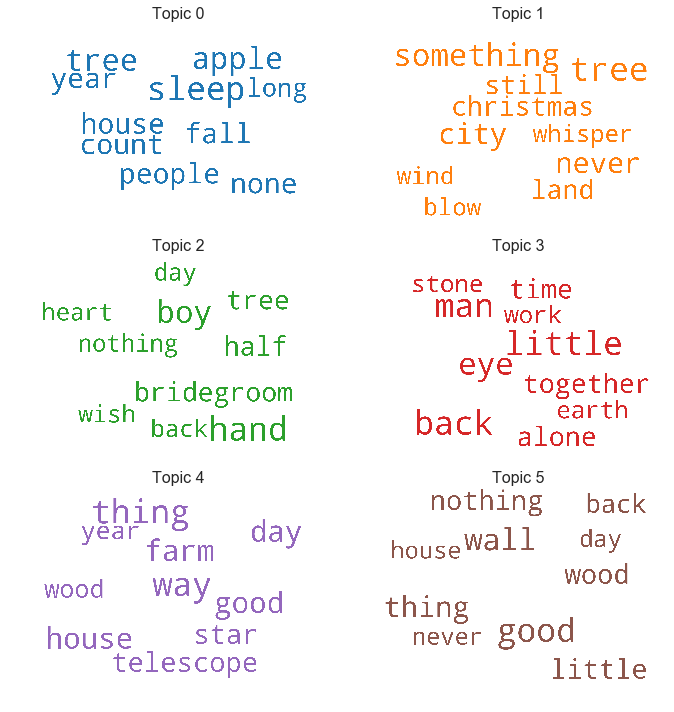

In [54]:
# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords = stops,
                  background_color = 'white',
                  width = 2500,
                  height = 1800,
                  max_words = 10,
                  colormap = 'tab10',
                  color_func = lambda *args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize = (10,10), sharex = True, sharey = True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size = 16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace = 0, hspace = 0)
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()

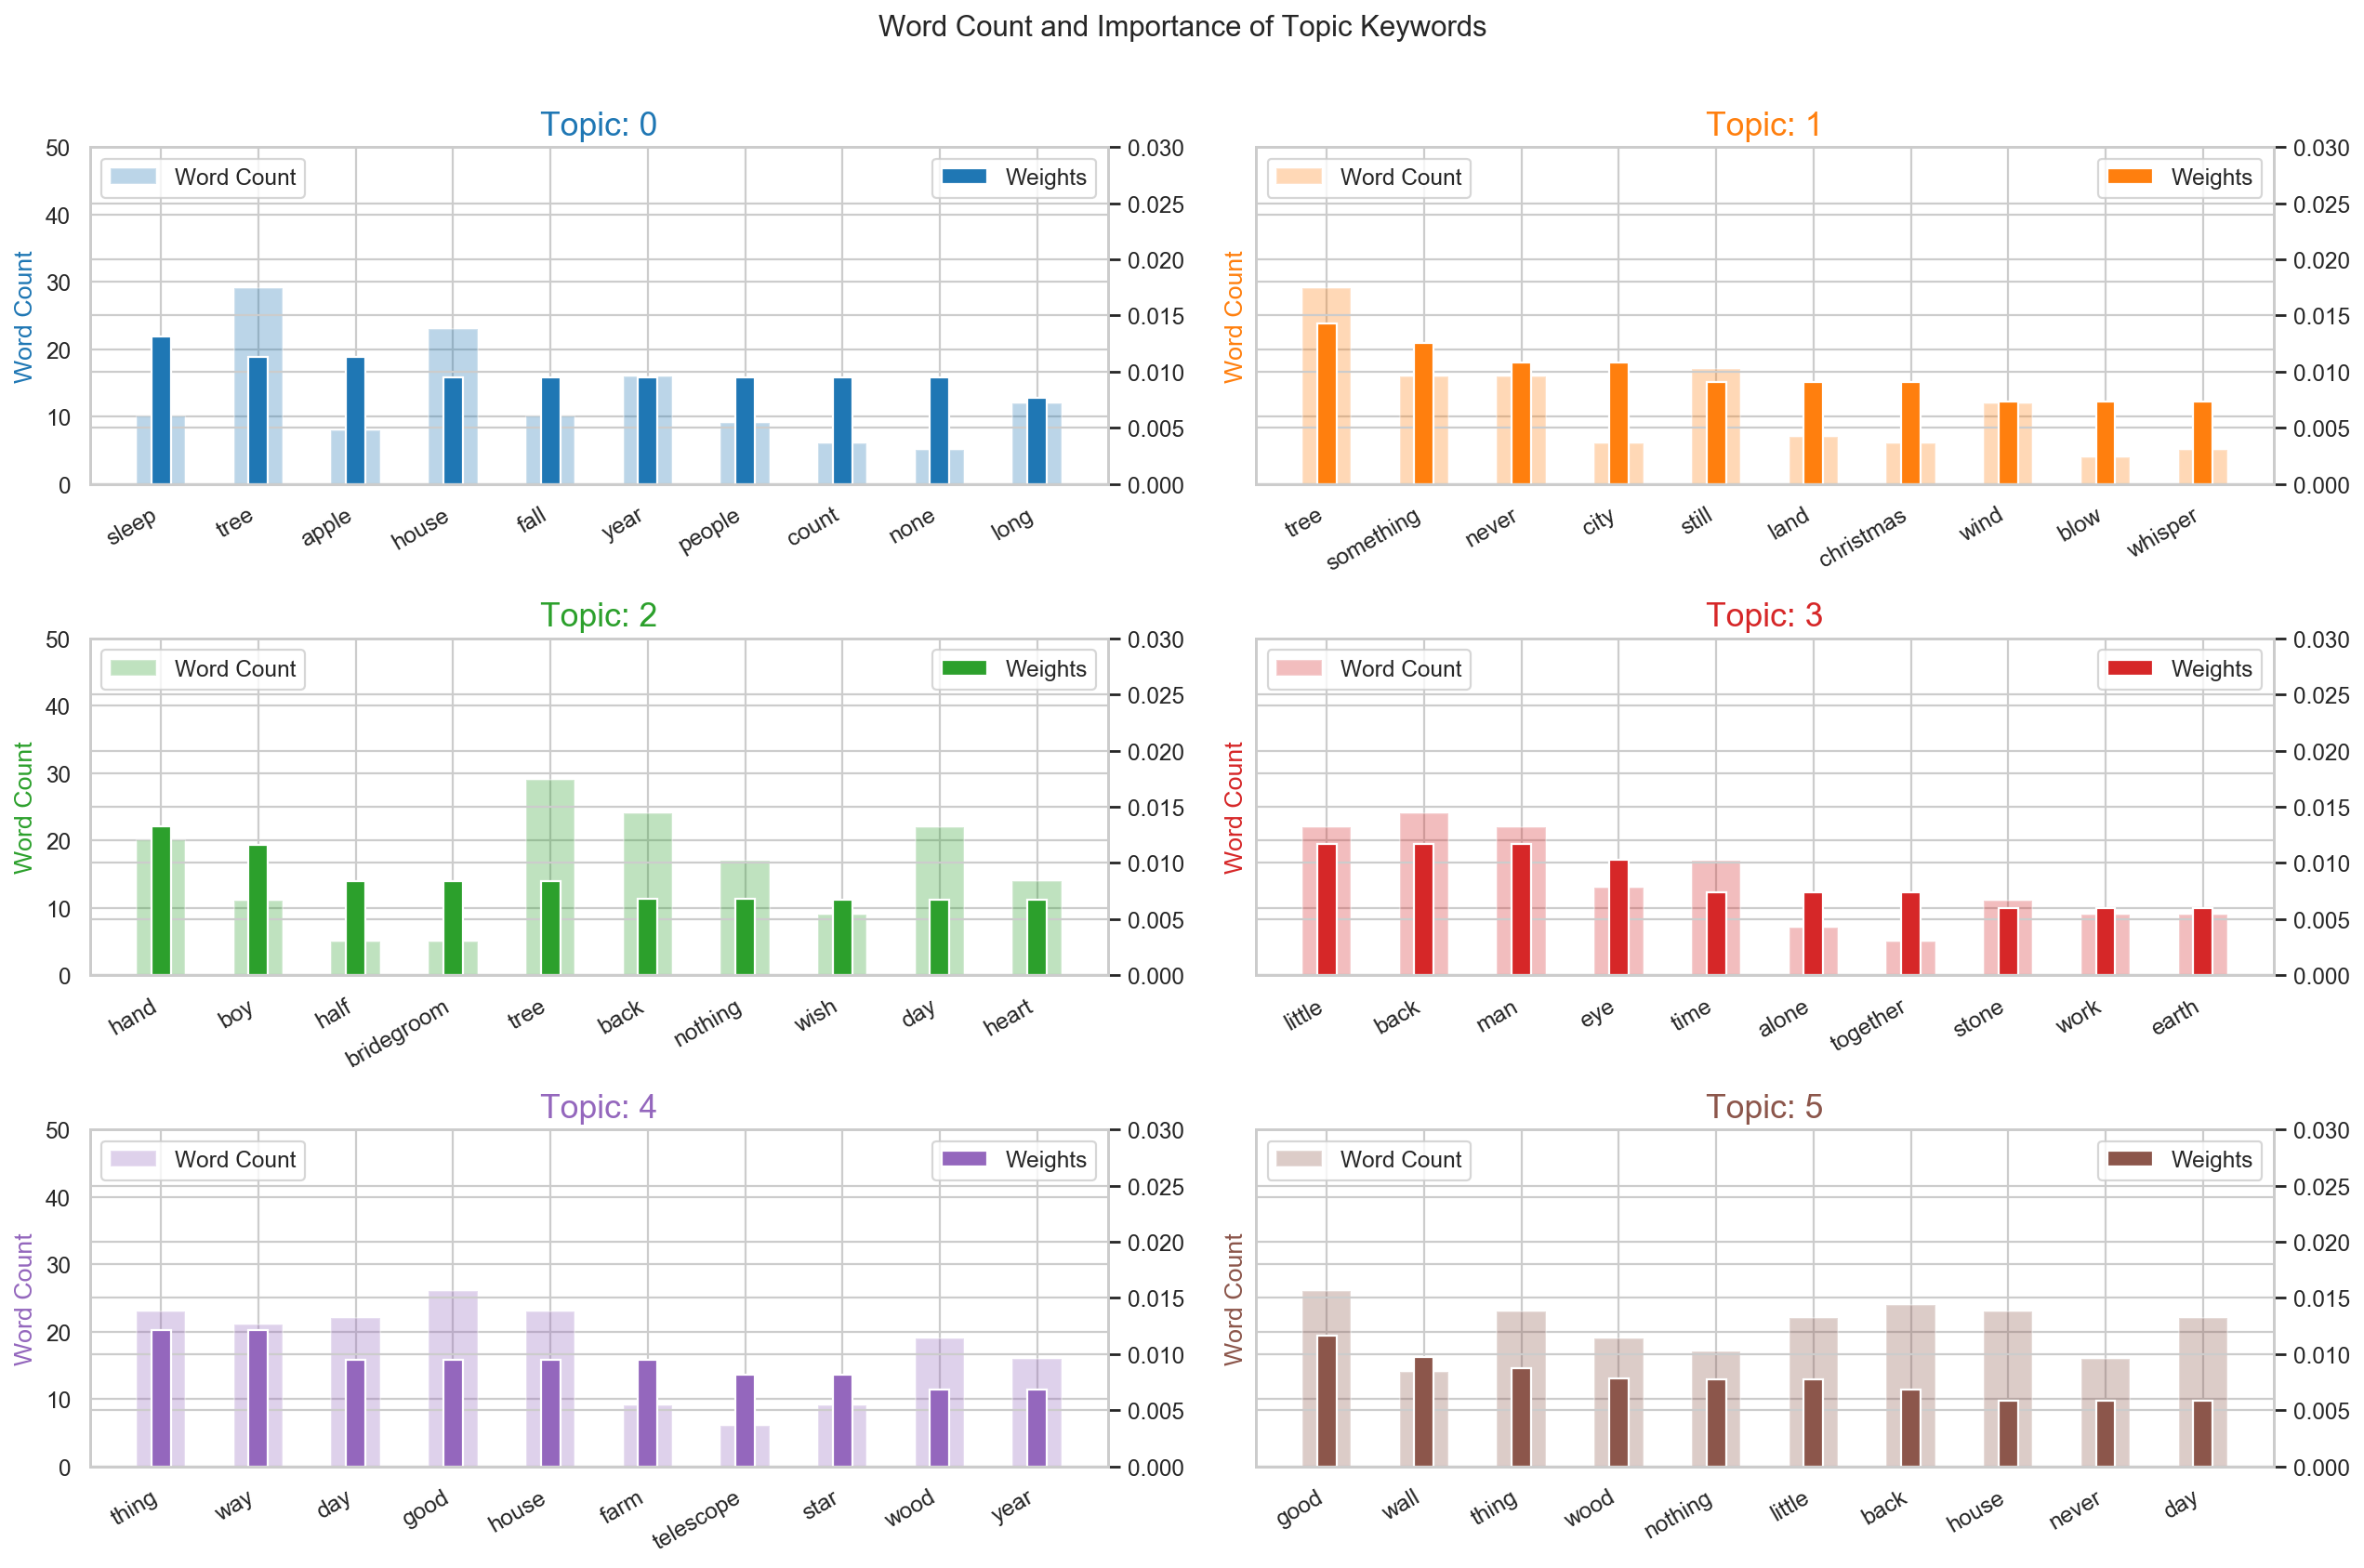

In [55]:
from collections import Counter
topics = lda_model.show_topics(formatted = False)
data_flat = [w for w_list in filtered_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize = (16,10), sharey = True, dpi = 160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x = 'word', 
           height = "word_count", 
           data = df.loc[df.topic_id == i, :], 
           color = cols[i], 
           width = 0.5, 
           alpha = 0.3, 
           label = 'Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x = 'word', 
                height = "importance", 
                data = df.loc[df.topic_id == i, :], 
                color = cols[i], width = 0.2,
                label ='Weights')
    ax.set_ylabel('Word Count', color = cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 50)
    ax.set_title('Topic: ' + str(i), color = cols[i], fontsize = 16)
    ax.tick_params(axis = 'y', left = False)
    ax.set_xticklabels(df.loc[df.topic_id == i, 'word'], 
                       rotation = 30, 
                       horizontalalignment = 'right')
    ax.legend(loc ='upper left')
    ax_twin.legend(loc = 'upper right')

fig.tight_layout(w_pad = 2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize = 14, y = 1.05)    
plt.show()

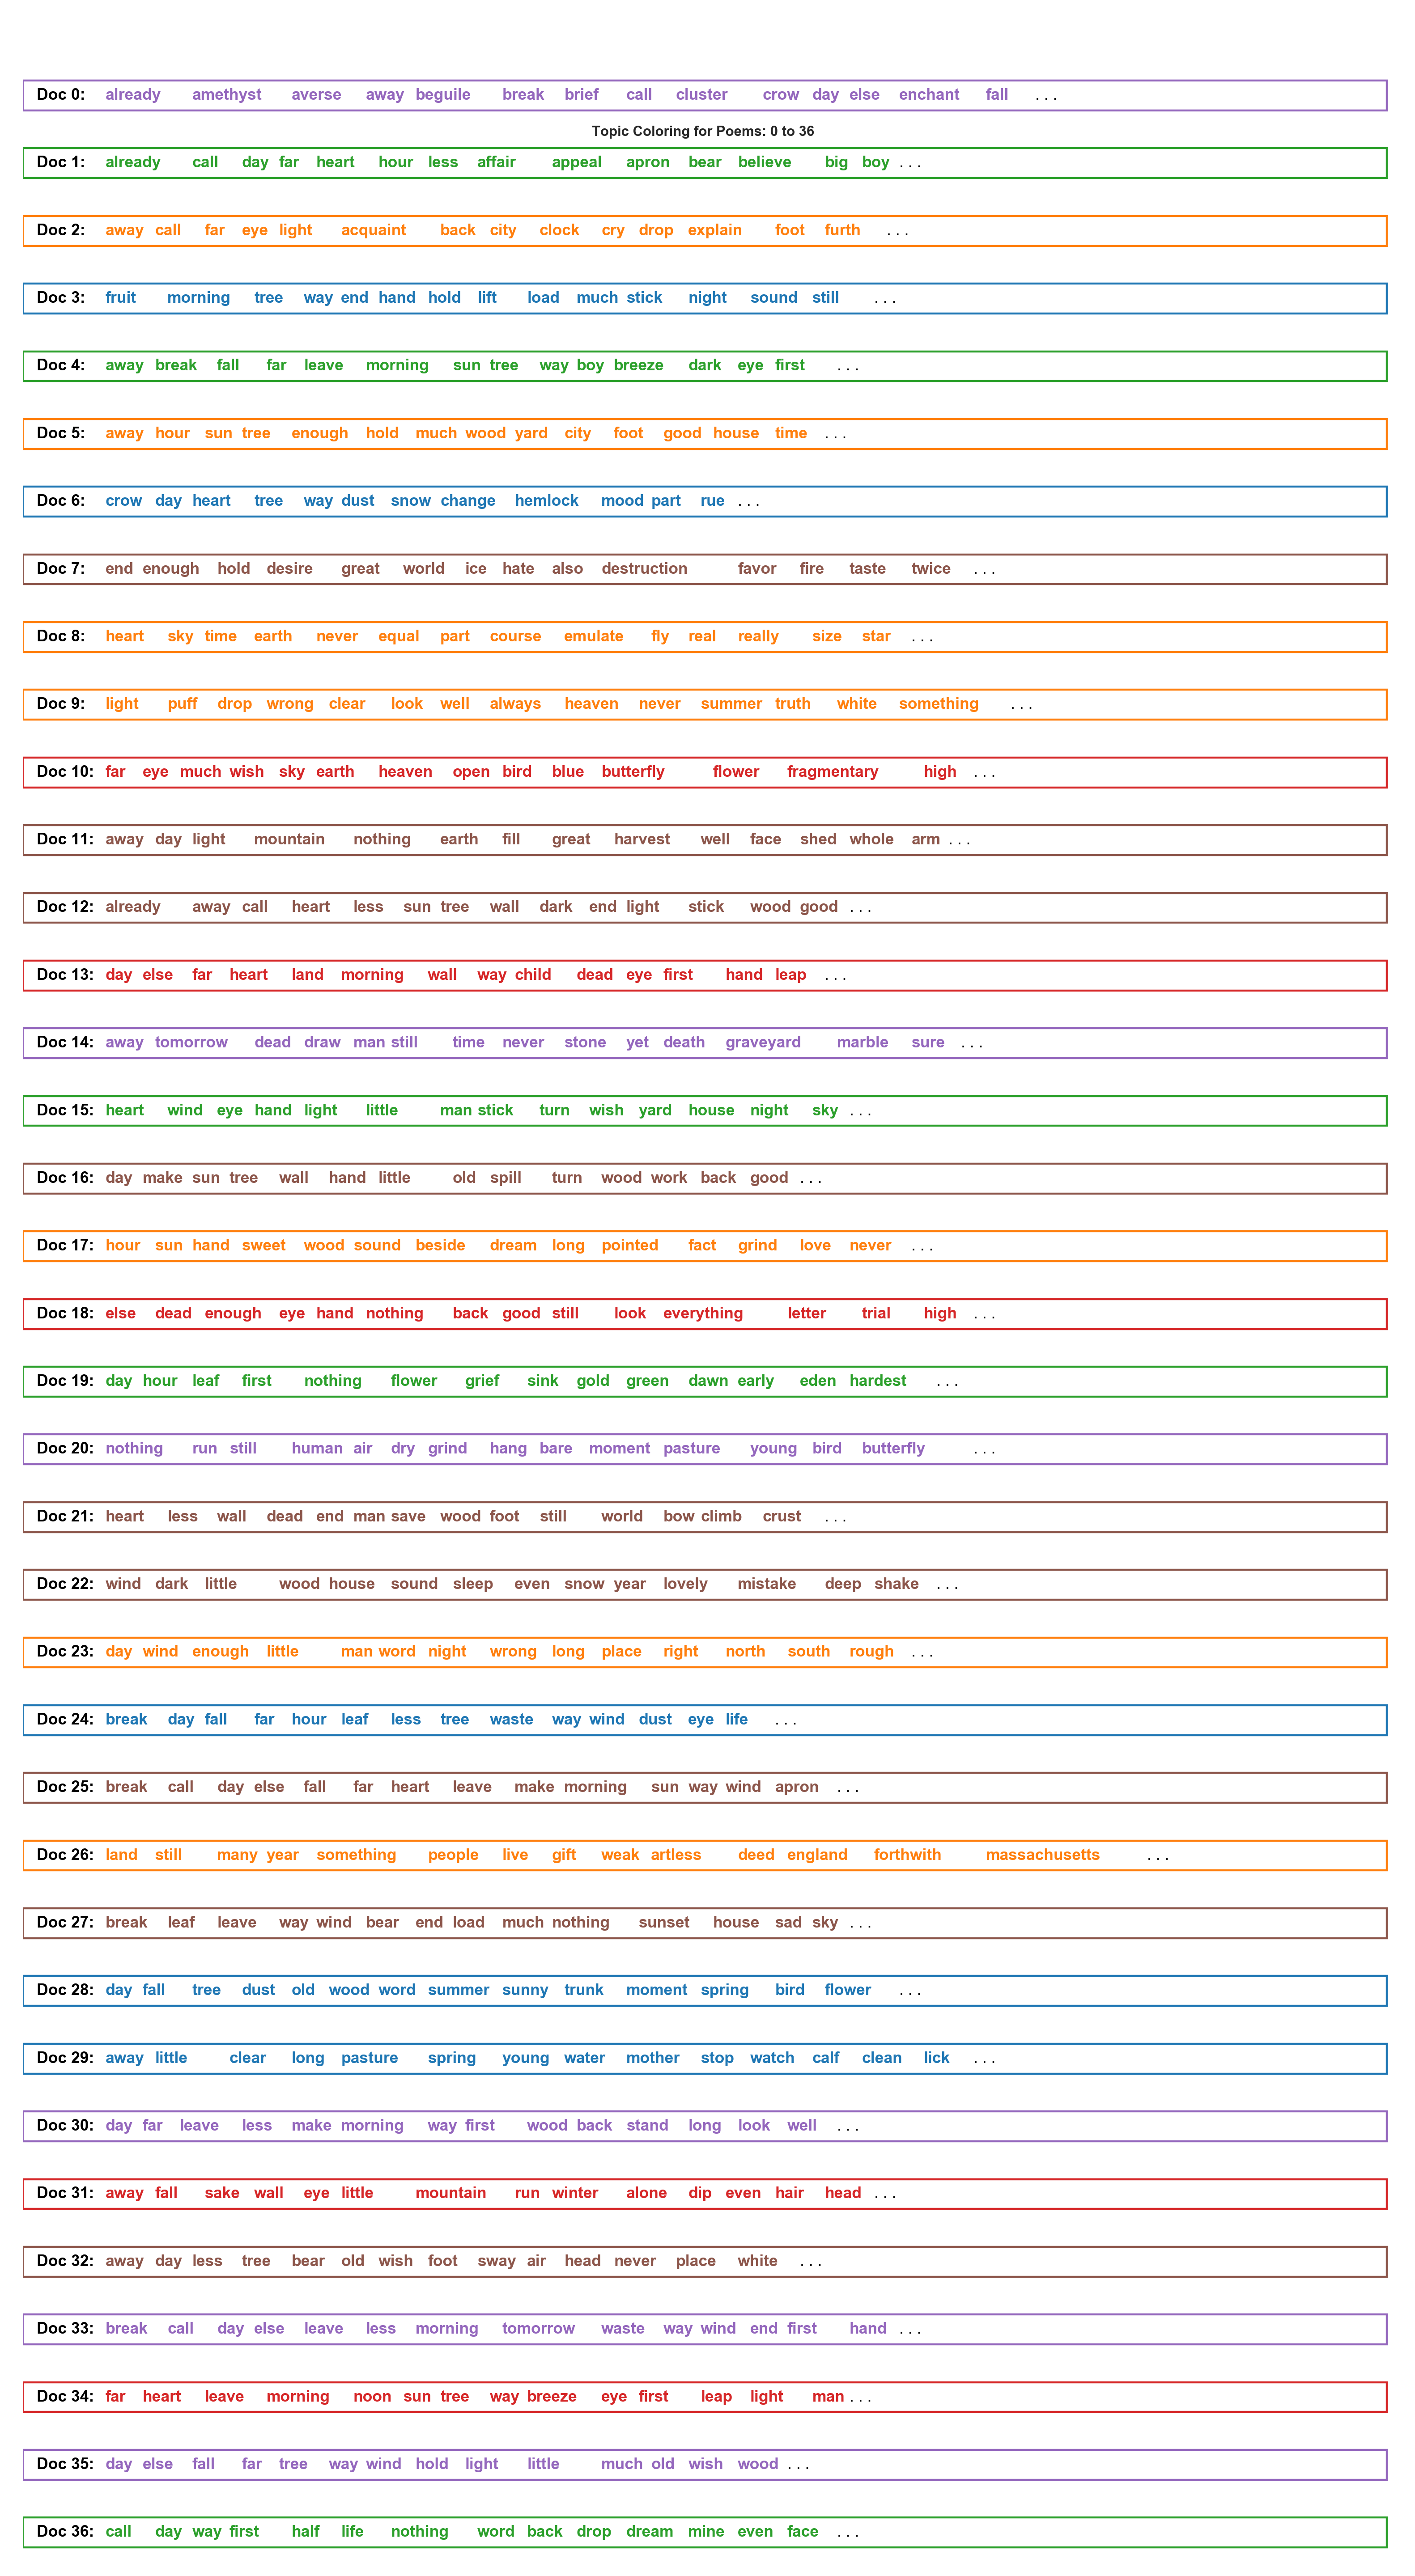

In [56]:
# Word colouring of N poems
from matplotlib.patches import Rectangle

def sentences_chart(lda_model = lda_model, corpus = corpus, start = 0, end = 38):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment = 'center',
                    fontsize = 16, color = 'black', transform = ax.transAxes, fontweight = 700)

            # Draw Rectangle
            topic_percs_sorted = sorted(topic_percs, key = lambda x: (x[1]), reverse = True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill = None, alpha = 1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth = 2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, 
                            color = mycolors[topics],
                            transform = ax.transAxes, 
                            fontweight = 700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment = 'left',
                    verticalalignment = 'center',
                    fontsize = 16, 
                    color = 'black',
                    transform = ax.transAxes)       

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.suptitle('Topic Coloring for Poems: ' + str(start) + ' to ' + str(end-2), \
                 fontsize = 14, y = 0.95, fontweight = 700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [57]:
# Define a function that identifies and quantifies the dominant topics
def topics_per_document(model, corpus, start = 0, end = 1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse = True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    
    return(dominant_topics, topic_percentages)

In [58]:
dominant_topics, topic_percentages = topics_per_document(model = lda_model, corpus = corpus, end = -1)

In [59]:
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns = ['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name = 'count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name = 'count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted = False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns = ['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level =0,inplace = True)

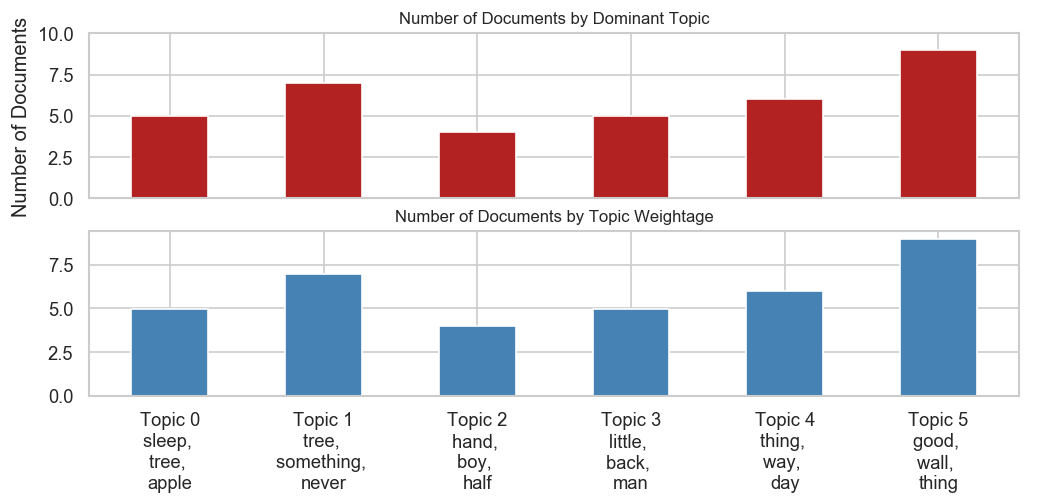

In [60]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 4), dpi = 120, sharex = True)

# Topic Distribution by Dominant Topics
ax1.bar(x = 'Dominant_Topic', 
        height = 'count', 
        data = df_dominant_topic_in_each_doc, 
        width = .5, color = 'firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + \
                               df_top3words.loc[df_top3words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size = 10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 10)

# Topic Distribution by Topic Weights
ax2.bar(x = 'index', 
        height = 'count', 
        data = df_topic_weightage_by_doc, 
        width = .5, color = 'steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict = dict(size = 10))

plt.show()

### Create a keyword network based on term frequency and TF-IDF
(use the "to_gephi.csv" and "to_gephi2.csv" files in Gephi for visualisation)
source: https://pythondata.com/text-analytics-visualization/

In [61]:
# Define a function that extracts the most common words per poem
def get_keywords(token_list, num):
    return Counter(token_list).most_common(num)

In [62]:
# Convert the filtered poems into strings
poemlist3 = [str(poem) for poem in poemlist2]
token_list = [word_tokenize(poem) for poem in poemlist3]

In [67]:
# titles = df1["title"].values.tolist()

df4 = pd.DataFrame({"title": poems, 
                    "poet": poets,
                    "filteredPoem": poemlist3})
df4.head()

,title,poet,filteredPoem
0,October,Robert Frost,hush october morning mild leave ripen fall tom...
1,"‘Out, Out—’",Robert Frost,buzz snarl rattle yard make dust drop stove-le...
2,Acquainted with the Night,Robert Frost,acquaint night walk rain and back rain outwalk...
3,After Apple-Picking,Robert Frost,long two-pointed ladder stick tree toward heav...
4,Birches,Robert Frost,birch bend leave right across line straighter ...


In [68]:
# Use the function to extract the top 5 words per poem
keywords = [get_keywords(tokens, 5) for tokens in token_list]

# Extract the list of keywords 
unzipped = [zip(*kw)for kw in keywords]
kw = [list(x)[0] for x in unzipped]

# Convert the list of keywords to a string
kw2 = [",".join(str(y) for y in x) for x in kw]

# Add the list of keywords to the dataframe
df4["keywords_TF"] = kw2
df4.head()

,title,poet,filteredPoem,keywords_TF
0,October,Robert Frost,hush october morning mild leave ripen fall tom...,"slow,hush,october,morning,mild"
1,"‘Out, Out—’",Robert Frost,buzz snarl rattle yard make dust drop stove-le...,"hand,snarl,rattle,half,count"
2,Acquainted with the Night,Robert Frost,acquaint night walk rain and back rain outwalk...,"acquaint,night,rain,back,city"
3,After Apple-Picking,Robert Frost,long two-pointed ladder stick tree toward heav...,"sleep,apples,keep,long,ladder"
4,Birches,Robert Frost,birch bend leave right across line straighter ...,"tree,like,birch,break,away"


In [69]:
# Add keywords based on TF-IDF
impt_words2 = df3.reset_index().groupby("PoemTitle")["Word"].apply(list)
df4["keywords_TF-IDF"] = [",".join(str(y) for y in x) for x in impt_words2]
df4.head()

,title,poet,filteredPoem,keywords_TF,keywords_TF-IDF
0,October,Robert Frost,hush october morning mild leave ripen fall tom...,"slow,hush,october,morning,mild","acquaint,city,furthest,outwalked,rain"
1,"‘Out, Out—’",Robert Frost,buzz snarl rattle yard make dust drop stove-le...,"hand,snarl,rattle,half,count","apple-picking,apples,ladder,sleep,thousand"
2,Acquainted with the Night,Robert Frost,acquaint night walk rain and back rain outwalk...,"acquaint,night,rain,back,city","birch,break,climb,learn,swinger"
3,After Apple-Picking,Robert Frost,long two-pointed ladder stick tree toward heav...,"sleep,apples,keep,long,ladder","cents,christmas,city,sell,thousand"
4,Birches,Robert Frost,birch bend leave right across line straighter ...,"tree,like,birch,break,away","crow,dust,hemlock,mood,part"


In [70]:
# Dataframe of keywords according to term frequency
keywordsTF = []
for i, r in df4.iterrows():
    keywords = r["keywords_TF"].split(",")
    for kw in keywords:
        keywordsTF.append((kw.strip(""), r["keywords_TF"]))
kwTF_df = pd.DataFrame(keywordsTF).rename(columns = {0: "keyword", 1: "keywords"})
kwTF_df.head()

,keyword,keywords
0,slow,"slow,hush,october,morning,mild"
1,hush,"slow,hush,october,morning,mild"
2,october,"slow,hush,october,morning,mild"
3,morning,"slow,hush,october,morning,mild"
4,mild,"slow,hush,october,morning,mild"


In [71]:
# Dataframe of keywords according to TF-IDF
keywordsTFIDF = []
for i, r in df4.iterrows():
    keywords = r["keywords_TF-IDF"].split(",")
    for kw in keywords:
        keywordsTFIDF.append((kw.strip(""), r["keywords_TF-IDF"]))
kwTFIDF_df = pd.DataFrame(keywordsTFIDF).rename(columns = {0: "keyword", 1: "keywords"})
kwTFIDF_df.head()

,keyword,keywords
0,acquaint,"acquaint,city,furthest,outwalked,rain"
1,city,"acquaint,city,furthest,outwalked,rain"
2,furthest,"acquaint,city,furthest,outwalked,rain"
3,outwalked,"acquaint,city,furthest,outwalked,rain"
4,rain,"acquaint,city,furthest,outwalked,rain"


#### TF

In [72]:
# Convert rows to lists
docsTF = kwTF_df["keywords"].tolist()
namesTF = kwTF_df["keyword"].tolist()

docs_list = [i.split(",")for i in docsTF]

In [73]:
# Create an ordered dictionary of keyword and frequency of co-occurrence
from collections import OrderedDict
occurrences = OrderedDict((name, OrderedDict((name, 0) for name in namesTF)) for name in namesTF)

for i in docs_list:
    for x in range(len(i)):
        for item in i[:x] + i[x + 1:]:
            occurrences[i[x]][item] += 1

# Create a dataframe of co-occurrences
co_occur_df = pd.DataFrame.from_dict(occurrences)         
co_occur_df.head()

,slow,hush,october,morning,mild,hand,snarl,rattle,half,count,...,work,turn,grass,together,year,mean,slumber,poems,breast,spread
.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acquaint,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apples,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
away,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
back,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
co_occur_df.to_csv("to_gephi.csv", sep = ",")

#### TF-IDF

In [75]:
# Convert rows to lists
docsTFIDF = kwTFIDF_df["keywords"].tolist()
namesTFIDF = kwTFIDF_df["keyword"].tolist()

docs_list = [i.split(",")for i in docsTFIDF]

In [76]:
# Create an ordered dictionary of keyword and frequency of co-occurrence
from collections import OrderedDict
occurrences2 = OrderedDict((name, OrderedDict((name, 0) for name in namesTFIDF)) for name in namesTFIDF)

for i in docs_list:
    for x in range(len(i)):
        for item in i[:x] + i[x + 1:]:
            occurrences2[i[x]][item] += 1

# Create a dataframe of co-occurrences
co_occur_df2 = pd.DataFrame.from_dict(occurrences2)         
co_occur_df2.head()

,acquaint,city,furthest,outwalked,rain,apple-picking,apples,ladder,sleep,thousand,...,dive,half-read,poems,slumber,tomb,half,hand,rattle,sister,snarl
achieve,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acquaint,0,5,5,5,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apple,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apple-picking,0,0,0,0,0,0,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
apples,0,0,0,0,0,5,0,5,5,5,...,0,0,0,0,0,0,0,0,0,0


In [77]:
co_occur_df2.to_csv("to_gephi2.csv", sep = ",")